## 统计分析

通过指定统计分析字段，得到每个特征的p_value，所有的p_value计算都是基于Ttest计算。支持指定不同的分组`group`，例如train、val、test等分组统计。

对于两大类不同的特征

1. 离散特征，统计数量以及占比。
2. 连续特征，统计均值、方差。

In [1]:
import pandas as pd
import numpy as np
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.utils import print_join_info

task = get_param_in_cwd('task_column') or 'label'
p_value = get_param_in_cwd('p_value') or 0.05
# 修改成自己临床数据的文件。
test_data = pd.read_csv(get_param_in_cwd('clinic_file'))
stats_columns_settings = get_param_in_cwd('stats_columns')
continuous_columns_settings = get_param_in_cwd('continuous_columns')
mapping_columns_settings = get_param_in_cwd('mapping_columns')
test_data = test_data[[c for c in test_data.columns if c != task]]
test_data['ID'] = test_data['ID'].map(lambda x: f"{x}.nii.gz" if not (f"{x}".endswith('.nii.gz') or  f"{x}".endswith('.nii')) else x)
group_info = pd.read_csv(get_param_in_cwd('label_file'))
print_join_info(test_data, group_info)
test_data = pd.merge(test_data, group_info, on='ID', how='inner')
test_data

[2025-04-22 20:51:20 - <frozen onekey_algo.custom.utils>:  63]	WARNING	存在ID特征不完全匹配的问题！在左边不在右边的ID：set()；在右边不在左边的ID：{'174.nii_+02.gz', '165.nii_-02.gz', '190.nii_-02.gz', '22.nii_-02.gz', '2.nii_-02.gz', '122.nii_+02.gz', '192.nii_+02.gz', '38.nii_-02.gz', '80.nii_-02.gz', '194.nii_+02.gz', '6.nii_+02.gz', '159.nii_+02.gz', '88.nii_-02.gz', '18.nii_-02.gz', '164.nii_-02.gz', '179.nii_-02.gz', '94.nii_-02.gz', '24.nii_+02.gz', '52.nii_-02.gz', '32.nii_+02.gz', '153.nii_-02.gz', '35.nii_+02.gz', '106.nii_+02.gz', '71.nii_+02.gz', '122.nii_-02.gz', '73.nii_+02.gz', '12.nii_+02.gz', '95.nii_-02.gz', '108.nii_+02.gz', '117.nii_+02.gz', '133.nii_+02.gz', '120.nii_-02.gz', '16.nii_-02.gz', '200.nii_-02.gz', '89.nii_-02.gz', '80.nii_+02.gz', '107.nii_+02.gz', '83.nii_+02.gz', '39.nii_-02.gz', '136.nii_-02.gz', '106.nii_-02.gz', '180.nii_-02.gz', '23.nii_-02.gz', '98.nii_+02.gz', '142.nii_-02.gz', '58.nii_-02.gz', '115.nii_+02.gz', '65.nii_-02.gz', '21.nii_+02.gz', '18.nii_+02.gz', '202.nii_-02.g

,ID,Gender,age,Enhancement pattern,Enhancement degree,Contour,necrotic,Lymphadenopathy,Pleural invasion,Great vessel invasion,Calcification,label,group
0,1.nii.gz,1,42,0,1,1,0,0,0,0,1,1,train
1,2.nii.gz,2,62,0,2,2,1,0,0,1,0,1,train
2,3.nii.gz,1,55,0,1,1,1,1,0,0,0,1,val
3,4.nii.gz,1,51,0,2,0,0,0,0,0,0,1,val
4,5.nii.gz,2,56,0,1,2,0,1,1,1,0,1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,453.nii.gz,1,63,0,2,1,0,0,0,0,0,0,test2
332,454.nii.gz,1,42,1,2,1,1,0,0,0,0,0,test2
333,455.nii.gz,2,51,1,1,1,0,1,0,0,1,0,test2
334,457.nii.gz,2,60,0,1,0,0,0,0,1,0,1,test2


# 特征名称处理

去掉所有特征名称中的特殊字符。

In [2]:
import re

def map_cnames(x):
    x = re.split('[（|(]', x)[0]
    x = x.replace('-', '_').replace(' ', '_').replace('>', '').replace('/', '_')
    return x.strip()

test_data.columns = list(map(map_cnames, test_data.columns))
test_data.columns

Index(['ID', 'Gender', 'age', 'Enhancement_pattern_', 'Enhancement_degree_',
       'Contour', 'necrotic', 'Lymphadenopathy', 'Pleural_invasion',
       'Great_vessel_invasion', 'Calcification', 'label', 'group'],
      dtype='object')

# 分析数据

获取待分析的特征列名，如未制定，自动侦测。

In [3]:
stats_columns = stats_columns_settings or list(test_data.columns[1:-2])
test_data = test_data.copy()[['ID'] + stats_columns + ['group', 'label']]
test_data

,ID,Gender,age,Enhancement_pattern_,Enhancement_degree_,Contour,necrotic,Lymphadenopathy,Pleural_invasion,Great_vessel_invasion,Calcification,group,label
0,1.nii.gz,1,42,0,1,1,0,0,0,0,1,train,1
1,2.nii.gz,2,62,0,2,2,1,0,0,1,0,train,1
2,3.nii.gz,1,55,0,1,1,1,1,0,0,0,val,1
3,4.nii.gz,1,51,0,2,0,0,0,0,0,0,val,1
4,5.nii.gz,2,56,0,1,2,0,1,1,1,0,train,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,453.nii.gz,1,63,0,2,1,0,0,0,0,0,test2,0
332,454.nii.gz,1,42,1,2,1,1,0,0,0,0,test2,0
333,455.nii.gz,2,51,1,1,1,0,1,0,0,1,test2,0
334,457.nii.gz,2,60,0,1,0,0,0,0,1,0,test2,1


# 特征队列映射

所有需要进行特征映射的队列，range未制定，可以进行自动判断。

In [4]:
mapping_columns = mapping_columns_settings or [c for c in test_data.columns[1:-2] if test_data[c].dtype == object]
mapping_columns

[]

# 数据映射

针对所有非数值形式的数据，可以进行类别映射。

In [5]:
from onekey_algo.custom.utils import map2numerical

data, mapping = map2numerical(test_data, mapping_columns=mapping_columns)
mapping

{}

In [6]:
from onekey_algo.custom.components.comp1 import fillna

data = fillna(data, fill_mod='50%')
continuous_columns = []
for col in test_data.columns:
    if test_data[col].apply(lambda x: x.is_integer() if isinstance(x, float) else False).all():
        test_data[col] = test_data[col].astype(int)

for c in stats_columns:
#     print(c, np.unique(test_data[c]), test_data[c].dtype)
    if len(np.unique(test_data[c])) > 5 or not np.int8 <= test_data[c].dtype <= np.int64:
        continuous_columns.append(c)
        
continuous_columns = continuous_columns_settings or continuous_columns
continuous_columns = [c for c in continuous_columns if c not in ('differentation')]
continuous_columns

['age']

# 缺失值填充

In [7]:
import os
os.makedirs('data', exist_ok=True)
data.to_csv('data/clinical.csv', index=False)
data

,ID,Gender,age,Enhancement_pattern_,Enhancement_degree_,Contour,necrotic,Lymphadenopathy,Pleural_invasion,Great_vessel_invasion,Calcification,group,label
0,1.nii.gz,1,42,0,1,1,0,0,0,0,1,train,1
1,2.nii.gz,2,62,0,2,2,1,0,0,1,0,train,1
2,3.nii.gz,1,55,0,1,1,1,1,0,0,0,val,1
3,4.nii.gz,1,51,0,2,0,0,0,0,0,0,val,1
4,5.nii.gz,2,56,0,1,2,0,1,1,1,0,train,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,453.nii.gz,1,63,0,2,1,0,0,0,0,0,test2,0
332,454.nii.gz,1,42,1,2,1,1,0,0,0,0,test2,0
333,455.nii.gz,2,51,1,1,1,0,1,0,0,1,test2,0
334,457.nii.gz,2,60,0,1,0,0,0,0,1,0,test2,1


### 统计分析

支持两种格式数据，分别对应`pretty`参数的`True`和`False`, 当为`True`时，输出的是表格模式，反之则为dict数据。

```python
def clinic_stats(data: DataFrame, stats_columns: Union[str, List[str]], label_column='label',
                 group_column: str = None, continuous_columns: Union[str, List[str]] = None,
                 pretty: bool = True) -> Union[dict, DataFrame]:
    """

    Args:
        data: 数据
        stats_columns: 需要统计的列名
        label_column: 二分类的标签列，默认`label`
        group_column: 分组统计依据，例如区分训练组、测试组、验证组。
        continuous_columns: 那些列是连续变量，连续变量统计均值方差。
        pretty: bool, 是否对结果进行格式美化。

    Returns:
        stats DataFrame or json

    """
```

In [8]:
from onekey_algo.custom.components.stats import clinic_stats

pd.set_option('display.max_rows', None)
stats = clinic_stats(data, 
                     stats_columns= stats_columns,
                     label_column=task, 
                     group_column='group', 
                     continuous_columns= continuous_columns, 
                     pretty=True, verbose=False)
stats.to_csv(f'data/stats_{task}.csv', index=False, encoding='utf_8_sig')
stats

,feature_name,test1-label=ALL,test1-label=0,test1-label=1,pvalue,test2-label=ALL,test2-label=0,test2-label=1,pvalue,train-label=ALL,train-label=0,train-label=1,pvalue,val-label=ALL,val-label=0,val-label=1,pvalue
0,age,54.81±12.13,57.07±11.58,53.53±12.35,0.237,54.69±10.12,53.67±11.08,55.15±9.80,0.642,55.29±10.85,56.63±9.65,54.72±11.32,0.337,55.89±10.45,57.39±10.09,55.27±10.64,0.474
0,Gender,,,,0.027,,,,0.138,,,,0.057,,,,0.044
1,1,53(63.86),14(46.67),39(73.58),,22(45.83),4(26.67),18(54.55),,82(57.34),19(44.19),63(63.00),,41(66.13),8(44.44),33(75.00),
2,2,30(36.14),16(53.33),14(26.42),,26(54.17),11(73.33),15(45.45),,61(42.66),24(55.81),37(37.00),,21(33.87),10(55.56),11(25.00),
3,Enhancement_pattern_,,,,0.205,,,,0.223,,,,0.637,,,,1.0
4,0,38(45.78),17(56.67),21(39.62),,15(31.25),7(46.67),8(24.24),,41(28.67),14(32.56),27(27.00),,15(24.19),4(22.22),11(25.00),
5,1,45(54.22),13(43.33),32(60.38),,33(68.75),8(53.33),25(75.76),,102(71.33),29(67.44),73(73.00),,47(75.81),14(77.78),33(75.00),
6,Enhancement_degree_,,,,0.011,,,,0.732,,,,0.003,,,,0.066
7,0,22(26.51),10(33.33),12(22.64),,12(25.00),4(26.67),8(24.24),,39(27.27),6(13.95),33(33.00),,15(24.19),1(5.56),14(31.82),
8,1,47(56.63),11(36.67),36(67.92),,23(47.92),6(40.00),17(51.52),,50(34.97),12(27.91),38(38.00),,20(32.26),6(33.33),14(31.82),


In [9]:
from onekey_algo.custom.components.stats import clinic_stats

pd.set_option('display.max_rows', None)
stats = clinic_stats(data, 
                     stats_columns= stats_columns,
                     label_column='group', 
                     group_column=None, 
                     continuous_columns= continuous_columns, 
                     pretty=True, verbose=False)
stats.to_csv('data/statics.csv', index=False, encoding='utf_8_sig')
stats

,feature_name,-label=ALL,-label=test1,-label=test2,-label=train,-label=val,pvalue
0,age,55.20±10.97,54.81±12.13,54.69±10.12,55.29±10.85,55.89±10.45,0.927
1,Gender,,,,,,0.127
2,1,198(58.93),53(63.86),22(45.83),82(57.34),41(66.13),
3,2,138(41.07),30(36.14),26(54.17),61(42.66),21(33.87),
4,Enhancement_pattern_,,,,,,0.022
5,0,109(32.44),38(45.78),15(31.25),41(28.67),15(24.19),
6,1,227(67.56),45(54.22),33(68.75),102(71.33),47(75.81),
7,Enhancement_degree_,,,,,,0.006
8,0,88(26.19),22(26.51),12(25.00),39(27.27),15(24.19),
9,1,140(41.67),47(56.63),23(47.92),50(34.97),20(32.26),


# 单因素多因素分析

单因素，步进多因素分析
```python
def uni_multi_variable_analysis(data: pd.DataFrame, features: Union[str, List[str]] = None, label_column: str = 'label',
                                need_norm: Union[bool, List[bool]] = False, alpha=0.1,
                                p_value4multi: float = 0.05, save_dir: Union[str] = None, prefix: str = '',
                                **kwargs):
    """
    单因素，步进多因素分析，使用p_value4multi参数指定多因素分析的阈值
    Args:
        data: 数据
        features: 需要分析的特征，默认除了ID和label_column列，其他的特征都进行分析。
        label_column: 目标列
        need_norm: 是否标准化所有分析的数据, 默认为False
        alpha: CI alpha, alpha/2 %；默认为0.1即95% CI
        p_value4multi: 参数指定多因素分析的阈值，默认为0.05
        save_dir: 保存位置
        prefix: 前缀
        **kwargs:

    Returns:

    """
 ```

,Log(OR),lower 95%CI,upper 95%CI,OR,OR lower 95%CI,OR upper 95%CI,p_value
feature_name,,,,,,,
Gender,0.453,0.255,0.650,1.573,1.290,1.916,0.000
age,0.014,0.009,0.019,1.014,1.009,1.019,0.000
Enhancement_pattern_,0.923,0.562,1.284,2.517,1.754,3.611,0.000
Enhancement_degree_,0.261,0.053,0.468,1.298,1.054,1.597,0.039
Contour,0.681,0.473,0.890,1.976,1.605,2.435,0.000
necrotic,0.865,0.465,1.265,2.375,1.592,3.543,0.000
Lymphadenopathy,1.492,0.885,2.098,4.445,2.423,8.150,0.000
Pleural_invasion,1.304,0.879,1.730,3.684,2.408,5.641,0.000
Great_vessel_invasion,1.112,0.733,1.491,3.040,2.081,4.442,0.000


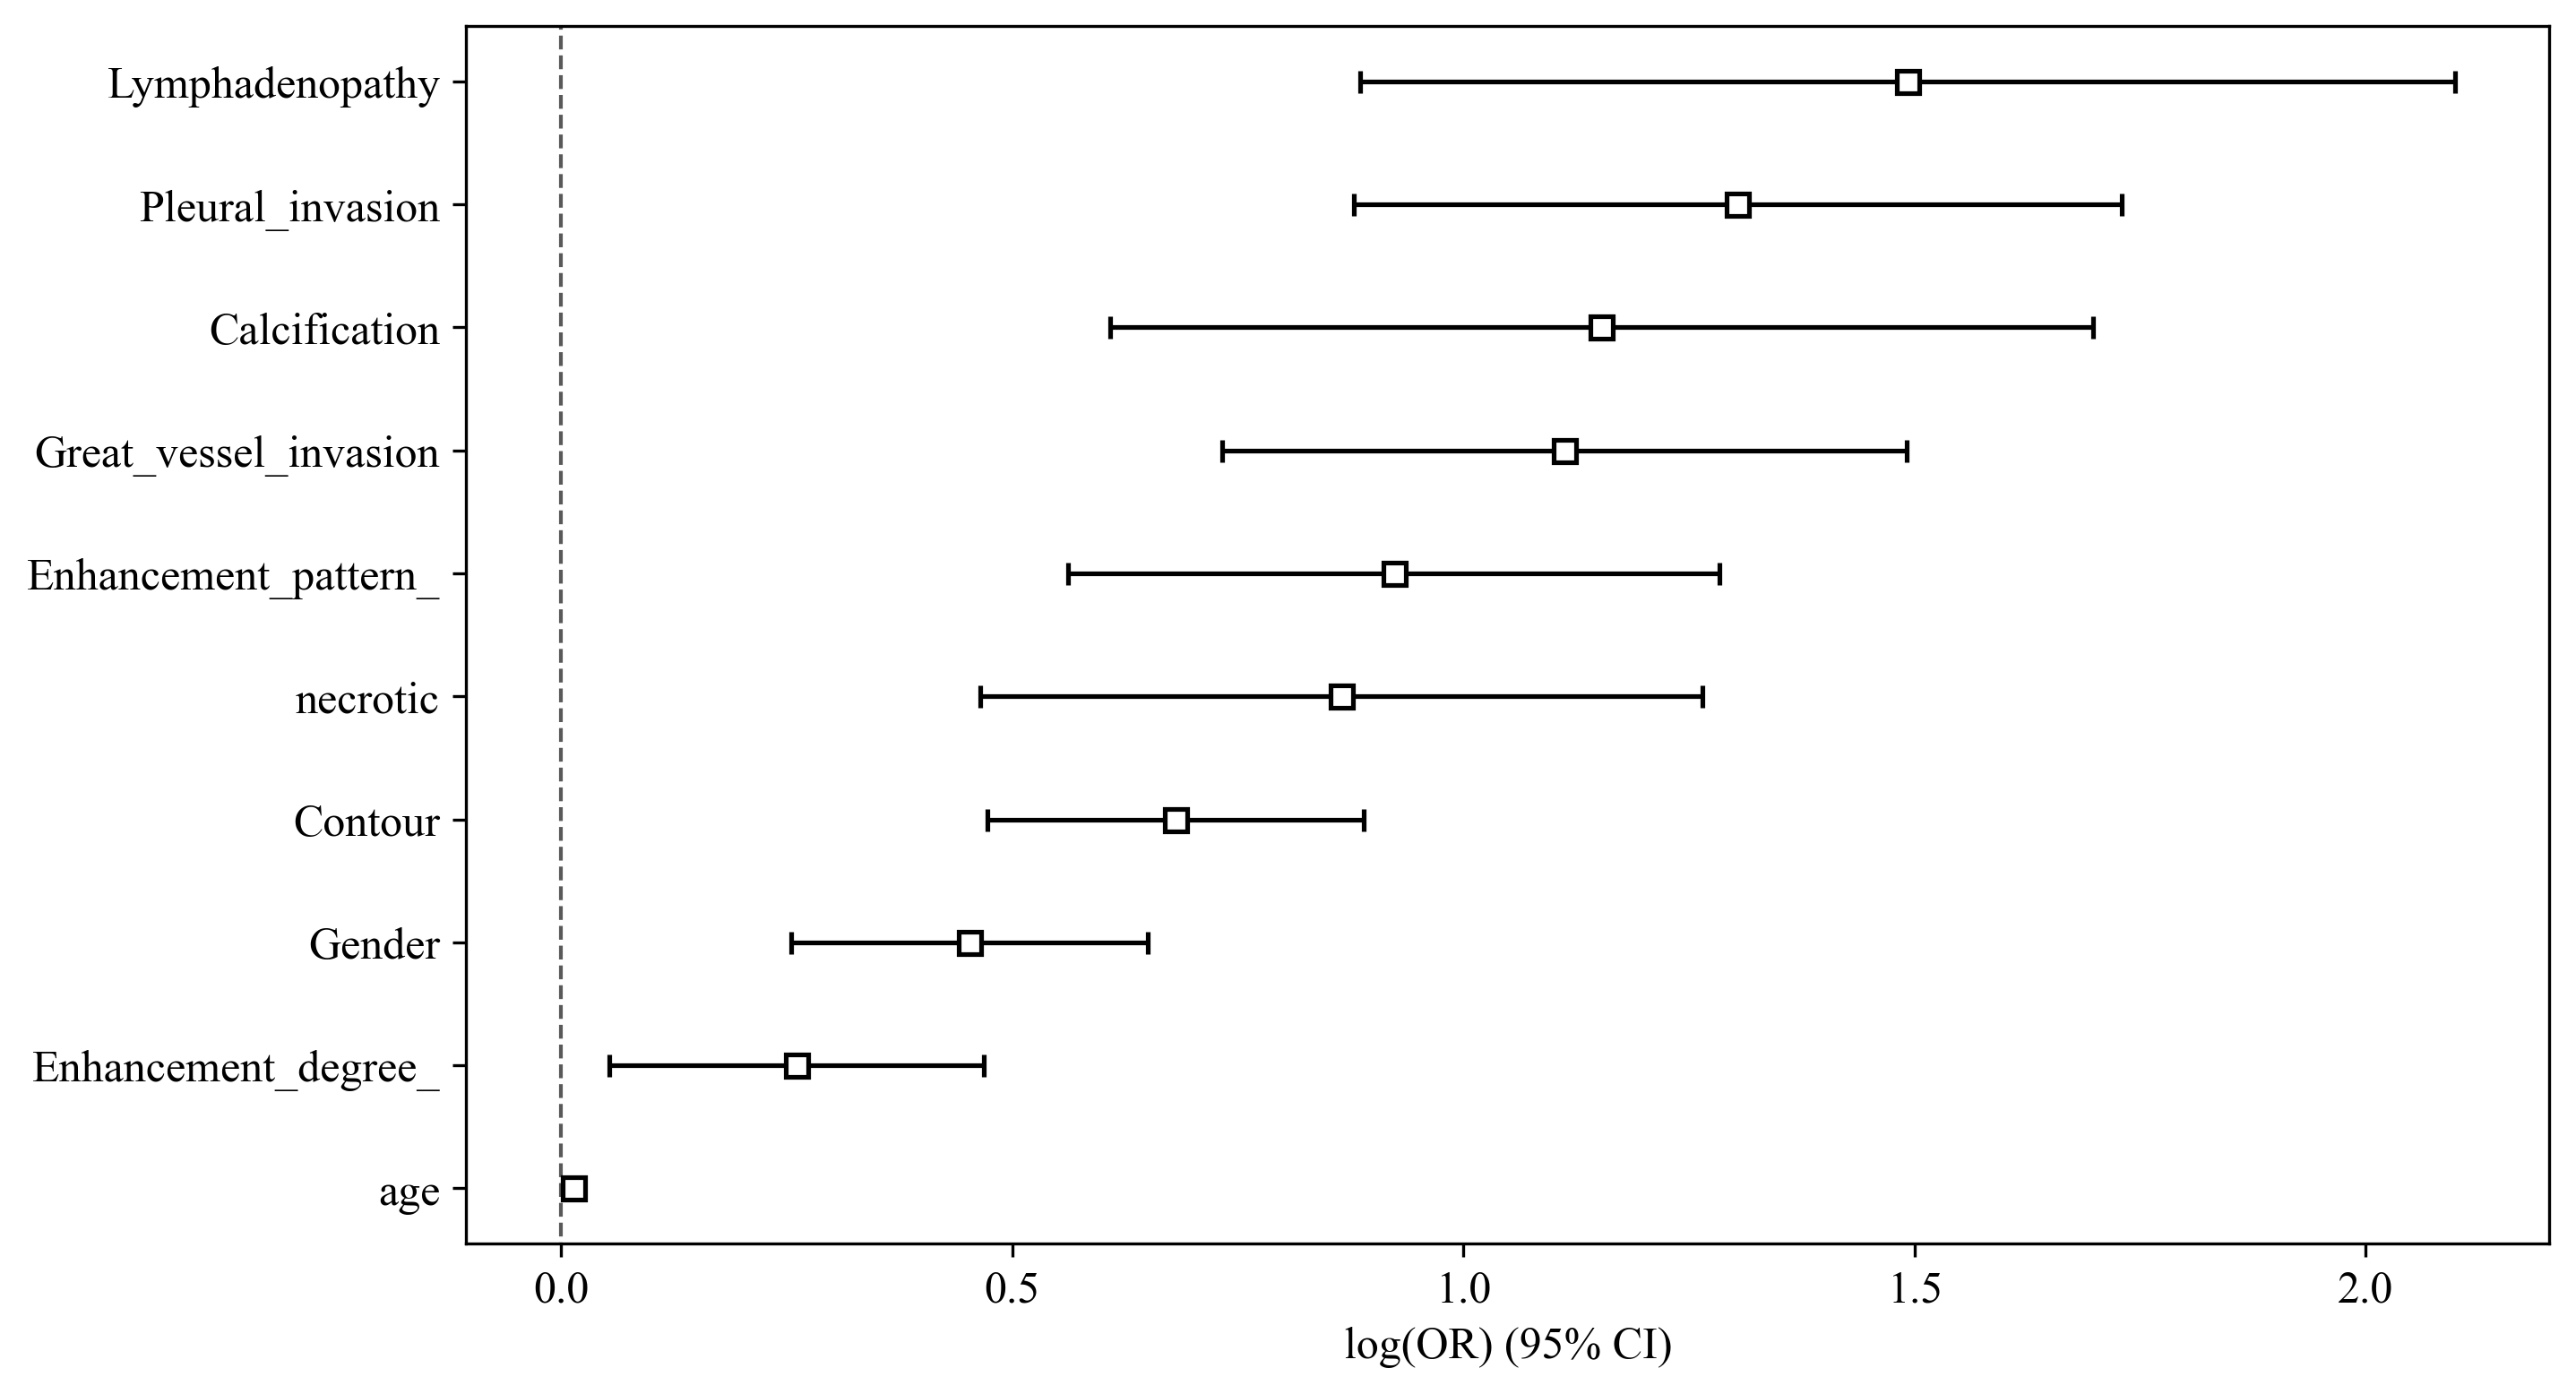

Optimization terminated successfully.
         Current function value: 0.523500
         Iterations 6


,Log(OR),lower 95%CI,upper 95%CI,OR,OR lower 95%CI,OR upper 95%CI,p_value
feature_name,,,,,,,
age,0.007,-0.014,0.028,1.007,0.986,1.028,0.591
Enhancement_degree_,-0.538,-1.034,-0.041,0.584,0.356,0.960,0.075
Gender,-0.241,-0.883,0.401,0.786,0.414,1.493,0.537
Contour,0.459,0.030,0.889,1.583,1.030,2.433,0.079
necrotic,-0.566,-1.444,0.312,0.568,0.236,1.366,0.289
Enhancement_pattern_,0.384,-0.461,1.229,1.468,0.631,3.418,0.455
Great_vessel_invasion,0.460,-0.373,1.293,1.584,0.689,3.644,0.364
Calcification,0.213,-0.546,0.971,1.237,0.579,2.641,0.645
Pleural_invasion,0.550,-0.228,1.327,1.733,0.796,3.770,0.245


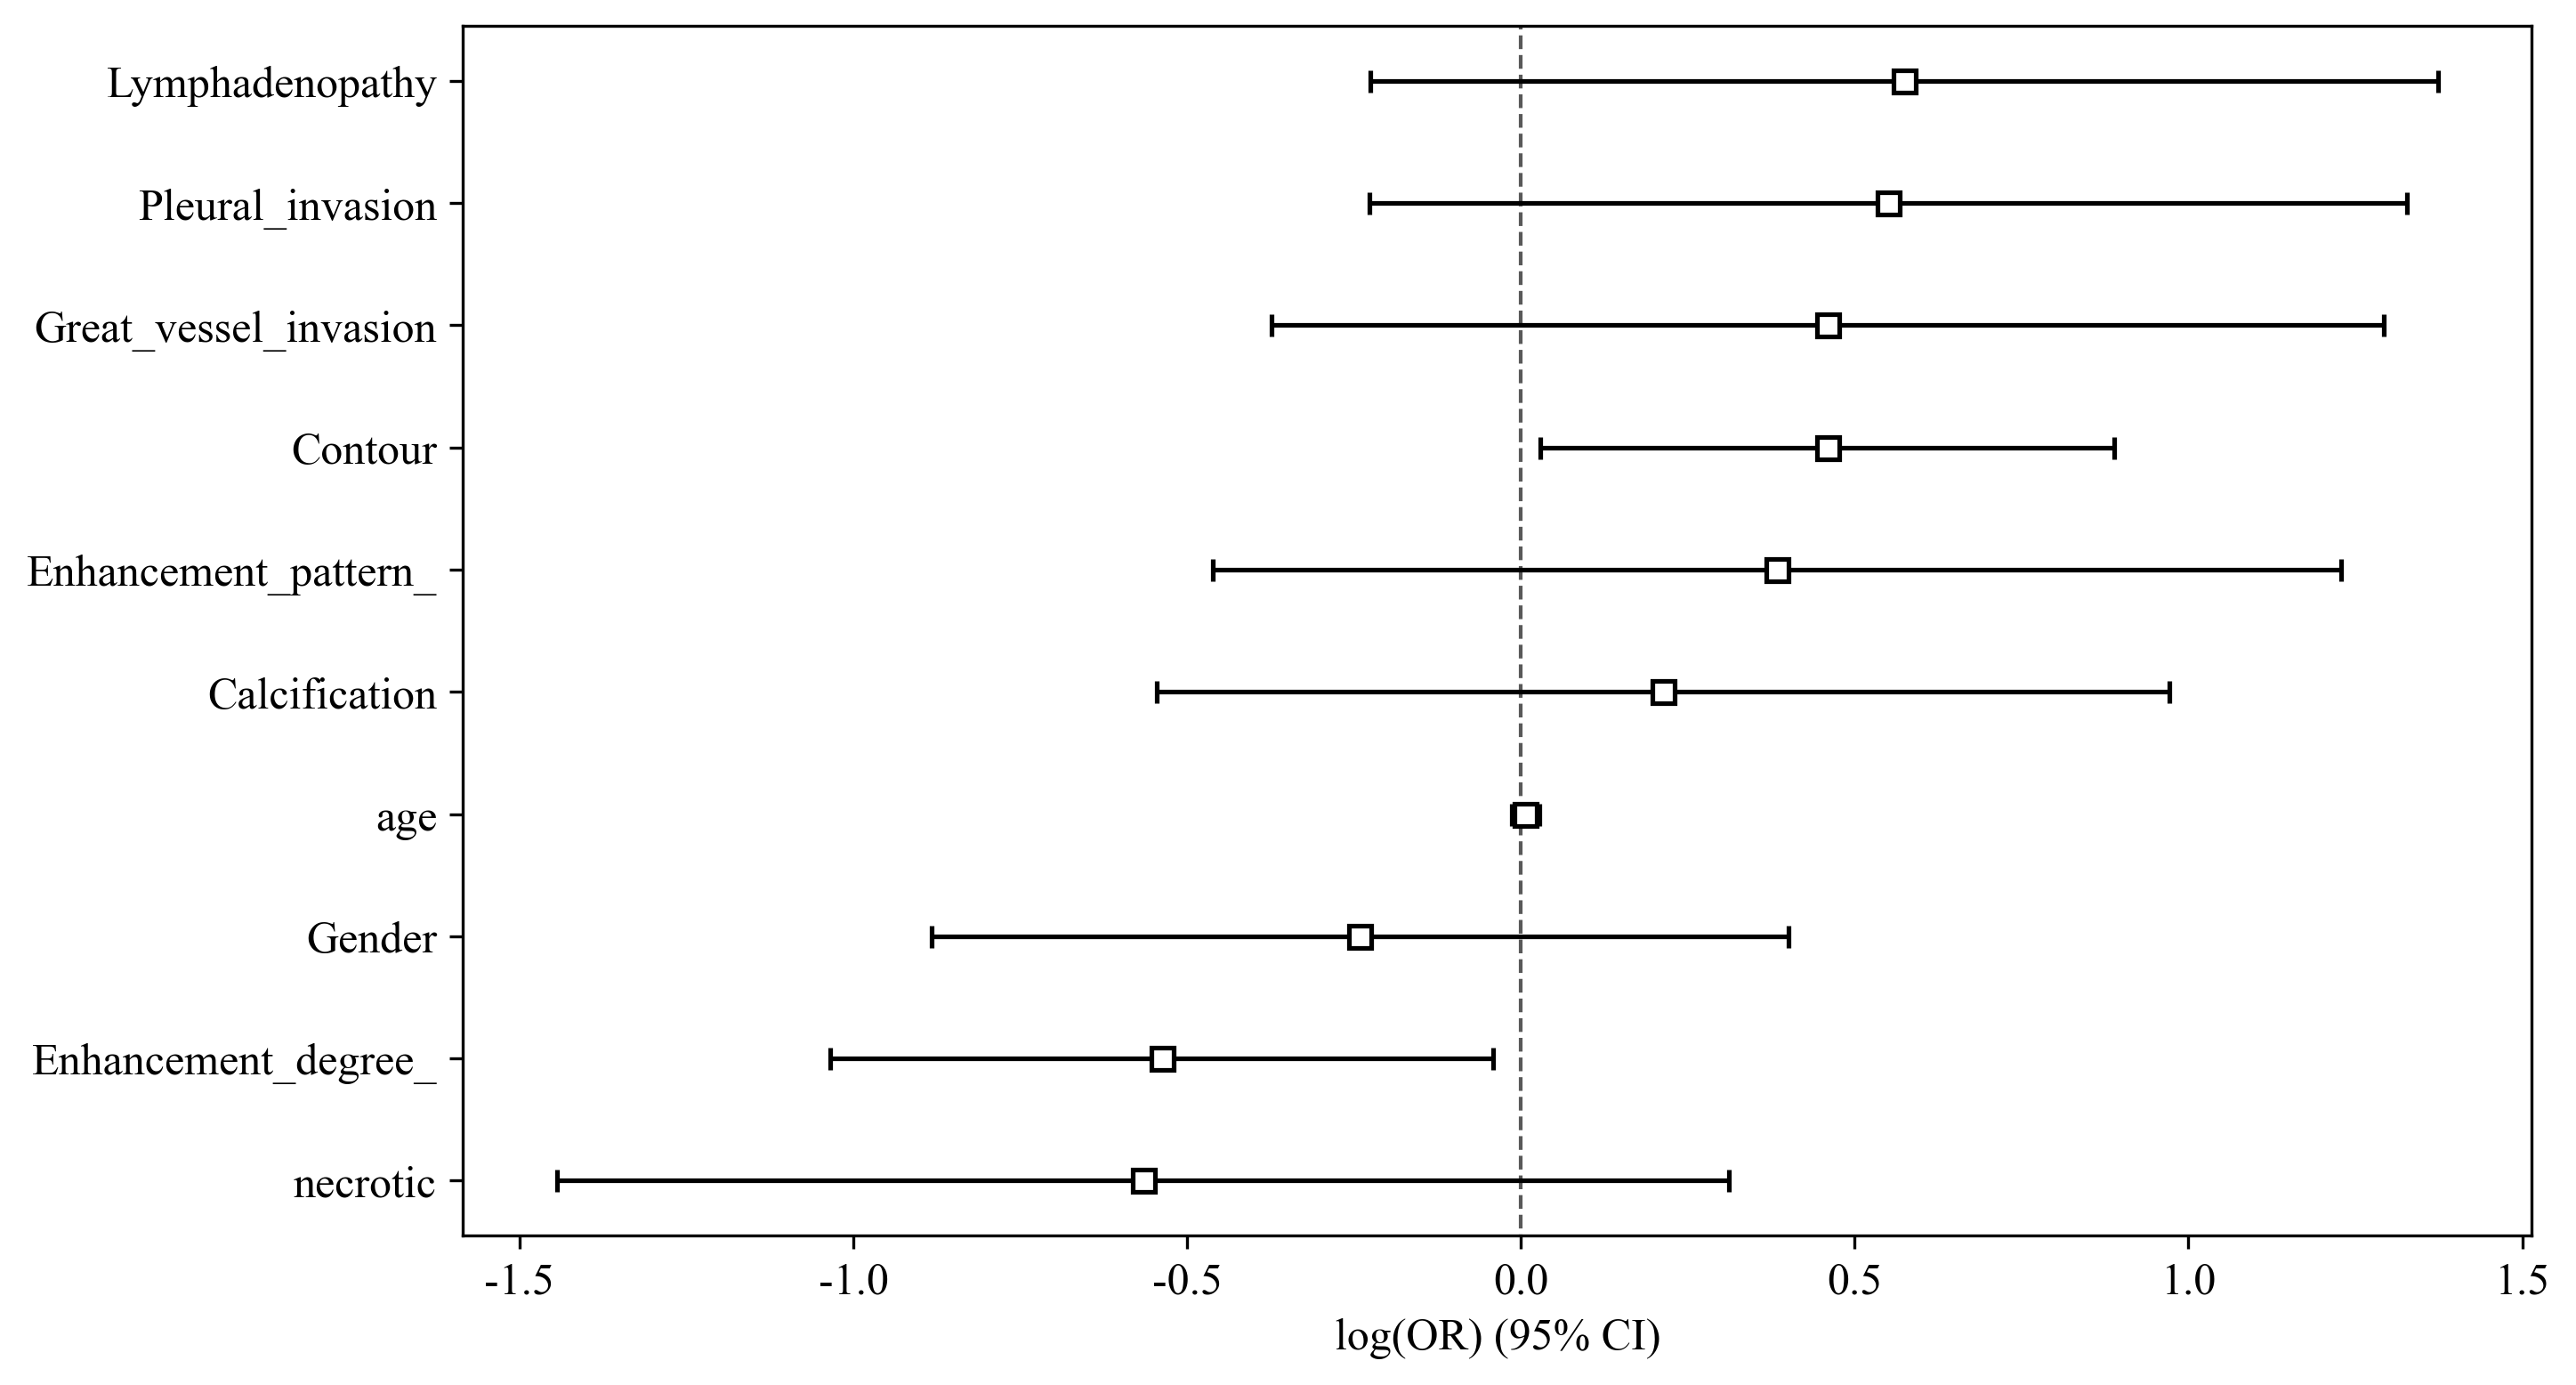

In [10]:
from onekey_algo.custom.components.comp1 import uni_multi_variable_analysis                        

uni_multi_variable_analysis(data[data['group'] == 'train'], stats_columns, save_dir='img', p_value4multi=p_value, algo='logit')

In [11]:
uni_v = pd.read_csv('img/multivariable_reg.csv')
uni_v = uni_v[uni_v['p_value'] <= 0.05]
sel_data = data[['ID'] + list(uni_v['feature_name']) + ['group', 'label']]
sel_data.to_csv('data/clinic_sel.csv', index=False)
sel_data

,ID,group,label
0,1.nii.gz,train,1
1,2.nii.gz,train,1
2,3.nii.gz,val,1
3,4.nii.gz,val,1
4,5.nii.gz,train,1
5,6.nii.gz,train,0
6,7.nii.gz,val,0
7,8.nii.gz,train,1
8,9.nii.gz,train,1
9,10.nii.gz,val,1


In [12]:
os.makedirs('results', exist_ok=True)
uni = pd.read_csv('img/univariable_reg.csv')
uni = uni[[c for c in uni if ('OR' in c and 'Log' not in c) or c in ['feature_name', 'p_value']]]
multi = pd.read_csv('img/multivariable_reg.csv')
multi = multi[[c for c in uni if ('OR' in c and 'Log' not in c) or c in ['feature_name', 'p_value']]]
info = pd.merge(uni, multi, on='feature_name', how='left', suffixes=['_UNI', '_MULTI']).applymap(lambda x: '' if pd.isna(x) else x)
info.to_csv('results/unimulti.csv', index=False)
info

,feature_name,OR_UNI,OR lower 95%CI_UNI,OR upper 95%CI_UNI,p_value_UNI,OR_MULTI,OR lower 95%CI_MULTI,OR upper 95%CI_MULTI,p_value_MULTI
0,age,1.014,1.009,1.019,0.000,1.007,0.986,1.028,0.591
1,Enhancement_degree_,1.298,1.054,1.597,0.039,0.584,0.356,0.960,0.075
2,Gender,1.573,1.290,1.916,0.000,0.786,0.414,1.493,0.537
3,Contour,1.976,1.605,2.435,0.000,1.583,1.030,2.433,0.079
4,necrotic,2.375,1.592,3.543,0.000,0.568,0.236,1.366,0.289
5,Enhancement_pattern_,2.517,1.754,3.611,0.000,1.468,0.631,3.418,0.455
6,Great_vessel_invasion,3.040,2.081,4.442,0.000,1.584,0.689,3.644,0.364
7,Calcification,3.167,1.837,5.458,0.000,1.237,0.579,2.641,0.645
8,Pleural_invasion,3.684,2.408,5.641,0.000,1.733,0.796,3.770,0.245
9,Lymphadenopathy,4.445,2.423,8.150,0.000,1.775,0.799,3.951,0.238
